# Imports and Paths

## Shared Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import itertools


## Plotting Parameters

In [2]:
from palettable.cartocolors.qualitative import Prism_8

prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = "#303039"
style = "/Users/gleung/OneDrive - Colostate/03 Resources/00 Code Repository/styles/bee-paperlight.mplstyle"
plt.style.use(style)


## Define paths

In [3]:
dataPath = (
    "/Users/gleung/OneDrive - Colostate/01 Projects/04.11_DroneChimney/00_Data/"
)

figPath = "/Users/gleung/OneDrive - Colostate/01 Projects/04.11_DroneChimney/02_Figures/"

# Process profiler drone logs

## Read-in manual flight logs

In [4]:
print(pd.Series(["PJ"]).str.lower())

0    pj
dtype: object


In [5]:
# This is the  manual flight log from BACS-II
log = pd.read_excel(f"{dataPath}log.xlsx", parse_dates=True)
log = log.rename(
    columns={
        "Date ": "Date",
        "Drone Altitude (m)": "Alt",
        "Takeoff TIme": "Takeoff",
        "Landing Time": "Landing",
        "In-stack time": "Instack",
        "Out-of-stack time": "Outstack",
        "iMet (Aspirated)": "Aspirated",
        "iMet (Unaspirated) Name": "Unaspirated",
    }
)
log = log[
    [
        "Date",
        "IOP",
        "Drone",
        "Flight Number",
        "Alt",
        "Takeoff",
        "Landing",
        "Instack",
        "Outstack",
        "Aspirated",
        "Unaspirated",
    ]
]

# don't include data from the first & last IOPs where we weren't using
# aspirated + unaspirated sensors anyway
log = log[(log.IOP > 15) & (log.IOP < 28)]

# exclude PJ since that was the profiler drone
log = log[log.Drone.str.lower() == "pj"]

# remove any flight segments that didn't have aspirated AND unaspirated sensors
log = log[(~log.Aspirated.isnull()) & (~log.Unaspirated.isnull())]

for i in log.index:
    for var in ["Takeoff", "Landing", "Instack", "Outstack"]:
        if not pd.isna(log.loc[i, var]):
            log.loc[i, var] = dt.datetime.combine(
                log.loc[i, "Date"].date(), log.loc[i, var]
            )
            if not log.loc[i, var].hour in ([10, 11, 12]):
                log.loc[i, var] = log.loc[i, var] + dt.timedelta(hours=12)

# convert local time to UTC
for var in ["Takeoff", "Landing", "Instack", "Outstack"]:
    log[f"{var}UTC"] = log[var] + dt.timedelta(hours=6)

## Coordinate with iMet Values

In [6]:
def clean_imet_data(
    path,
    imetCols=[
        "XQ-iMet-XQ Pressure",
        "XQ-iMet-XQ Air Temperature",
        "XQ-iMet-XQ Humidity",
        "XQ-iMet-XQ Humidity Temp",
        "XQ-iMet-XQ Date",
        "XQ-iMet-XQ Time",
        "XQ-iMet-XQ Longitude",
        "XQ-iMet-XQ Latitude",
        "XQ-iMet-XQ Altitude",
        "XQ-iMet-XQ Sat Count",
    ],
    imetnewCols=[
        "P",
        "Temp",
        "RH",
        "Temp_RH",
        "Date",
        "Time",
        "Lon",
        "Lat",
        "Alt",
        "SatCount",
    ],
):
    df = pd.read_csv(path, parse_dates=True)
    df = df[imetCols]
    df.columns = imetnewCols

    df = df[df.Date.str[:4] == "2023"]
    df = df[df.Date.str[8:10] != "00"]

    df = df[df.SatCount > 0]

    df["Datetime"] = pd.to_datetime(df.Date + " " + df.Time)

    return df

In [8]:
for t in log.index:
    flt = log.loc[t]

    print(flt.IOP, flt["Flight Number"], flt.Drone)

    # make sure both aspirated and unaspirated iMet files exist
    if os.path.exists(
        f"{dataPath}/imet/{flt.Aspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
    ) and os.path.exists(
        f"{dataPath}/imet/{flt.Unaspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
    ):

        # read aspirated imet
        aPath = (
            f"{dataPath}/imet/{flt.Aspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
        )
        a = clean_imet_data(aPath)
        # use manual takeoff/landing times as initial guess
        a = a[(a.Datetime >= flt.TakeoffUTC) & (a.Datetime <= flt.LandingUTC)]
        a = a.reset_index()

        # read unaspirated imet
        uPath = f"{dataPath}/imet/{flt.Unaspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
        u = clean_imet_data(uPath)
        # use manual takeoff/landing times as initial guess
        u = u[(u.Datetime >= flt.TakeoffUTC) & (u.Datetime <= flt.LandingUTC)]
        u = u.reset_index()

        if (len(u) > 60) & (len(a) > 60) & (np.abs(len(a) - len(u)) <= 60):
            # plot the segments as sanity check
            """fig, axes = plt.subplots(4, 1)

            for ax, var in zip(axes, ["Temp", "Alt", "Lat", "Lon"]):
                ax.plot(a["Datetime"], a[var], color=red)
                ax.plot(u["Datetime"], u[var], color="black")

                ax.axvline(flt.TakeoffUTC)
                ax.axvline(flt.LandingUTC)

            plt.show()
            plt.close("all")"""

            # assign new start and end time to log dataframe
            log.loc[t, "starttime"] = u.Datetime.iloc[0]
            log.loc[t, "endtime"] = u.Datetime.iloc[-1]

16 1 PJ
16 2 PJ
17 1 Pj
17 2 Pj
17 3 Pj
18 1 Pj
18 2 Pj
18 3 Pj
18 4 Pj
18 5 Pj
18 6 Pj
18 7 Pj
19 1 Pj
19 2 Pj
19 3 Pj
19 4 Pj
19 5 Pj
20 1 Pj
20 2 Pj
20 3 Pj
20 4 Pj
21 1 Pj
22 1 Pj
22 2 Pj
22 3 Pj
23 1 Pj
23 2 Pj
23 3 Pj
23 4 Pj
23 5 Pj
23 6 Pj
23 7 Pj
24 1 Pj
24 2 Pj
24 3 Pj
25 1 Pj
25 2 Pj
25 3 Pj
25 4 Pj
25 5 Pj
25 6 Pj
25 7 Pj
26 1 Pj
26 2 Pj
26 3 Pj
26 4 Pj
26 5 Pj
26 6 Pj
27 1 Pj
27 2 Pj


## Mark periods of ascent/descent

In [7]:
def split_consecutive_groups(lst):
    # this is a function to split list into groups of repeated values
    return [list(group) for key, group in itertools.groupby(lst)]

In [181]:
prof = pd.DataFrame(
    columns=[
        "Date",
        "IOP",
        "Type",
        "Flight",
        "profid",
        "starttime",
        "endtime",
        "Aspirated",
        "Unaspirated",
    ]
)

for t in log.index:
    flt = log.loc[t]

    print(flt.IOP, flt["Flight Number"], flt.Drone)

    # make sure both aspirated and unaspirated iMet files exist
    if os.path.exists(
        f"{dataPath}/imet/{flt.Aspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
    ) and os.path.exists(
        f"{dataPath}/imet/{flt.Unaspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
    ):

        # read aspirated imet
        aPath = (
            f"{dataPath}/imet/{flt.Aspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
        )
        a = clean_imet_data(aPath)
        # use manual takeoff/landing times as initial guess
        a = a[(a.Datetime >= flt.TakeoffUTC) & (a.Datetime <= flt.LandingUTC)]
        a = a.reset_index()

        # read unaspirated imet
        uPath = f"{dataPath}/imet/{flt.Unaspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
        u = clean_imet_data(uPath)
        # use manual takeoff/landing times as initial guess
        u = u[(u.Datetime >= flt.TakeoffUTC) & (u.Datetime <= flt.LandingUTC)]
        u = u.reset_index()

        if (len(u) > 60) & (len(a) > 60) & (np.abs(len(a) - len(u)) <= 60):
            u["ascentrate"] = u.Alt.diff()
            u["ascentrate_mean"] = u.ascentrate.rolling(30, center=True).mean()
            u["ascentvar"] = u.ascentrate.rolling(30, center=True).std()

            u["ascentflag"] = (u["ascentrate_mean"] >= 0.5) & (
                u["ascentvar"] <= 1
            )

            # find groups where altitude flag is consecutive 1 or 0
            grps = split_consecutive_groups(u["ascentflag"])
            lens = np.array([len(l) for l in grps])
            cumlen = lens.cumsum()

            for i, g in enumerate(grps):
                if g[0]:  # if ascending
                    # when the next gap in ascent flag is < 30s, just combine it
                    if lens[i + 1] <= 30:
                        u.loc[cumlen[i] : cumlen[i + 1] - 1, "ascentflag"] = (
                            True
                        )

            grps = split_consecutive_groups(u["ascentflag"])
            lens = np.array([len(l) for l in grps])
            cumlen = lens.cumsum()

            # assign each ascent period its own id
            id = 0
            u["ascentid"] = np.nan
            for i, g in enumerate(grps[:-1]):
                if i > 0:
                    if g[0]:
                        u.loc[cumlen[i - 1] : cumlen[i] - 1, "ascentid"] = id
                        id += 1
                    else:
                        u.loc[cumlen[i - 1] : cumlen[i] - 1, "ascentid"] = (
                            np.nan
                        )

            u["descentflag"] = (u["ascentrate_mean"] <= -0.5) & (
                u["ascentvar"] <= 1
            )

            # find groups where altitude flag is consecutive 1 or 0
            grps = split_consecutive_groups(u["descentflag"])
            lens = np.array([len(l) for l in grps])
            cumlen = lens.cumsum()

            for i, g in enumerate(grps):
                if g[0]:  # if descending
                    # when the next gap in ascent flag is < 30s, just combine it
                    if lens[i + 1] <= 30:
                        u.loc[cumlen[i] : cumlen[i + 1] - 1, "descentflag"] = (
                            True
                        )

            grps = split_consecutive_groups(u["descentflag"])
            lens = np.array([len(l) for l in grps])
            cumlen = lens.cumsum()

            u["descentid"] = np.nan
            id = 0
            for i, g in enumerate(grps[:-1]):
                if i > 0:
                    if g[0]:
                        u.loc[cumlen[i - 1] : cumlen[i] - 1, "descentid"] = id
                        id += 1
                    else:
                        u.loc[cumlen[i - 1] : cumlen[i] - 1, "descentid"] = (
                            np.nan
                        )

            asc = (
                u.groupby("ascentid")
                .Datetime.agg({"first", "last", "count"})
                .reset_index()
            )
            dsc = (
                u.groupby("descentid")
                .Datetime.agg({"first", "last", "count"})
                .reset_index()
            )

            asc.columns = [
                "profid",
                "endtime",
                "starttime",
                "count",
            ]
            asc["Date"] = flt.Date
            asc["IOP"] = flt.IOP
            asc["Flight"] = flt["Flight Number"]
            asc["Type"] = "ascending"
            asc["Aspirated"] = flt.Aspirated
            asc["Unaspirated"] = flt.Unaspirated

            dsc.columns = [
                "profid",
                "endtime",
                "starttime",
                "count",
            ]
            dsc["Date"] = flt.Date
            dsc["IOP"] = flt.IOP

            dsc["Flight"] = flt["Flight Number"]
            dsc["Type"] = "descending"
            dsc["Aspirated"] = flt.Aspirated
            dsc["Unaspirated"] = flt.Unaspirated

            # being quite strict with screening here
            # ascending and descending legs should be more than 75s (technically should take ~115s to do
            # full leg, but the screening will cut some time out at the very top/bottom of profile)
            asc = asc[asc["count"] >= 75]
            dsc = dsc[dsc["count"] >= 75]

            # plot for sanity check
            fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 12))

            axes[0].plot(u.Datetime, u.Temp, color="black", label="Unshielded")
            axes[0].plot(a.Datetime, a.Temp, color=red, label="Shielded")
            axes[0].legend()
            axes[0].set_ylabel("$^{\circ}$C")
            axes[0].set_title("(a) Temperature")

            axes[1].plot(u.Datetime, u.Alt, color="black")
            axes[1].set_title("(b) Altitude")
            axes[1].set_ylabel("m (MSL)")

            axes[2].plot(u.Datetime, u.ascentrate, color="black")
            axes[2].axhline(0, ls="--")
            axes[2].axhline(3, ls="--")
            axes[2].axhline(-3, ls="--")
            axes[2].set_title("(c) Ascent Rate")
            axes[2].set_ylabel("m/s")

            axes[3].plot(u.Datetime, u.ascentvar, color="black")
            axes[3].axhline(1)
            axes[3].set_title("(d) Ascent Rate Variability")
            axes[3].set_ylabel("m/s")

            for ax in axes:
                for i in asc.index:
                    ax.axvspan(
                        asc.loc[i, "starttime"],
                        asc.loc[i, "endtime"],
                        alpha=0.5,
                        color=red,
                    )

                for i in dsc.index:
                    ax.axvspan(
                        dsc.loc[i, "starttime"],
                        dsc.loc[i, "endtime"],
                        alpha=0.5,
                        color=blue,
                    )

            plt.suptitle(
                f"IOP {flt.IOP}, Flight {flt['Flight Number']}",
                fontsize=20,
                ha="center",
                va="center",
            )

            plt.savefig(
                f"{figPath}/profile_identification/{flt.IOP}_{flt['Flight Number']}.png"
            )
            plt.close("all")

            prof = pd.concat([prof, asc, dsc])

16 1 PJ
16 2 PJ
17 1 Pj
17 2 Pj
17 3 Pj
18 1 Pj
18 2 Pj
18 3 Pj
18 4 Pj
18 5 Pj
18 6 Pj
18 7 Pj
19 1 Pj
19 2 Pj
19 3 Pj
19 4 Pj
19 5 Pj
20 1 Pj
20 2 Pj
20 3 Pj
20 4 Pj
21 1 Pj
22 1 Pj
22 2 Pj
22 3 Pj
23 1 Pj
23 2 Pj
23 3 Pj
23 4 Pj
23 5 Pj
23 6 Pj
23 7 Pj
24 1 Pj
24 2 Pj
24 3 Pj
25 1 Pj
25 2 Pj
25 3 Pj
25 4 Pj
25 5 Pj
25 6 Pj
25 7 Pj
26 1 Pj
26 2 Pj
26 3 Pj
26 4 Pj
26 5 Pj
26 6 Pj
27 1 Pj
27 2 Pj


In [182]:
prof = prof.reset_index()

In [183]:
prof.to_csv(f"{dataPath}/prof_log.csv")

In [12]:
prof = pd.read_csv(f"{dataPath}/prof_log.csv")

In [18]:
prof["Date"] = pd.to_datetime(prof.Date)

# Compare ascending and descending profiles

In [19]:
altbin = 5
ver = "ascending"

a = []
for i in prof[prof.Type == ver].index:
    flt = prof.loc[i]

    out = []

    if os.path.exists(
        f"{dataPath}/imet/{flt['Aspirated']}-{flt.Date.strftime('%Y%m%d')}.csv"
    ) & os.path.exists(
        f"{dataPath}/imet/{flt['Unaspirated']}-{flt.Date.strftime('%Y%m%d')}.csv"
    ):

        for ver in ["Aspirated", "Unaspirated"]:
            path = (
                f"{dataPath}/imet/{flt[ver]}-{flt.Date.strftime('%Y%m%d')}.csv"
            )

            df = clean_imet_data(path)

            df = df[
                (df.Datetime >= flt.starttime) & (df.Datetime <= flt.endtime)
            ]

            df = df.set_index("Datetime")

            out.append(df)

        if (len(out[0]) > 0) & (len(out[1]) > 0):

            out = pd.merge(
                out[0],
                out[1],
                how="outer",
                on="Datetime",
                suffixes=["_asp", "_un"],
            ).dropna()

    # out = out.groupby(altbin * (out.Alt_un // altbin))[
    #    ["Temp_asp", "Temp_un"]
    # ].mean()

    a.append(out)

a = pd.concat(a).reset_index()

In [20]:
ver = "descending"

d = []
for i in prof[prof.Type == ver].index:
    flt = prof.loc[i]

    out = []

    if os.path.exists(
        f"{dataPath}/imet/{flt['Aspirated']}-{flt.Date.strftime('%Y%m%d')}.csv"
    ) & os.path.exists(
        f"{dataPath}/imet/{flt['Unaspirated']}-{flt.Date.strftime('%Y%m%d')}.csv"
    ):

        for ver in ["Aspirated", "Unaspirated"]:
            path = (
                f"{dataPath}/imet/{flt[ver]}-{flt.Date.strftime('%Y%m%d')}.csv"
            )

            df = clean_imet_data(path)

            df = df[
                (df.Datetime >= flt.starttime) & (df.Datetime <= flt.endtime)
            ]

            df = df.set_index("Datetime")

            out.append(df)

        if (len(out[0]) > 0) & (len(out[1]) > 0):

            out = pd.merge(
                out[0],
                out[1],
                how="outer",
                on="Datetime",
                suffixes=["_asp", "_un"],
            ).dropna()

    # out = out.groupby(altbin * (out.Alt_un // altbin))[
    #    ["Temp_asp", "Temp_un"]
    # ].mean()

    d.append(out)

d = pd.concat(d).reset_index()

Text(0.0, 1.0, 'Descending')

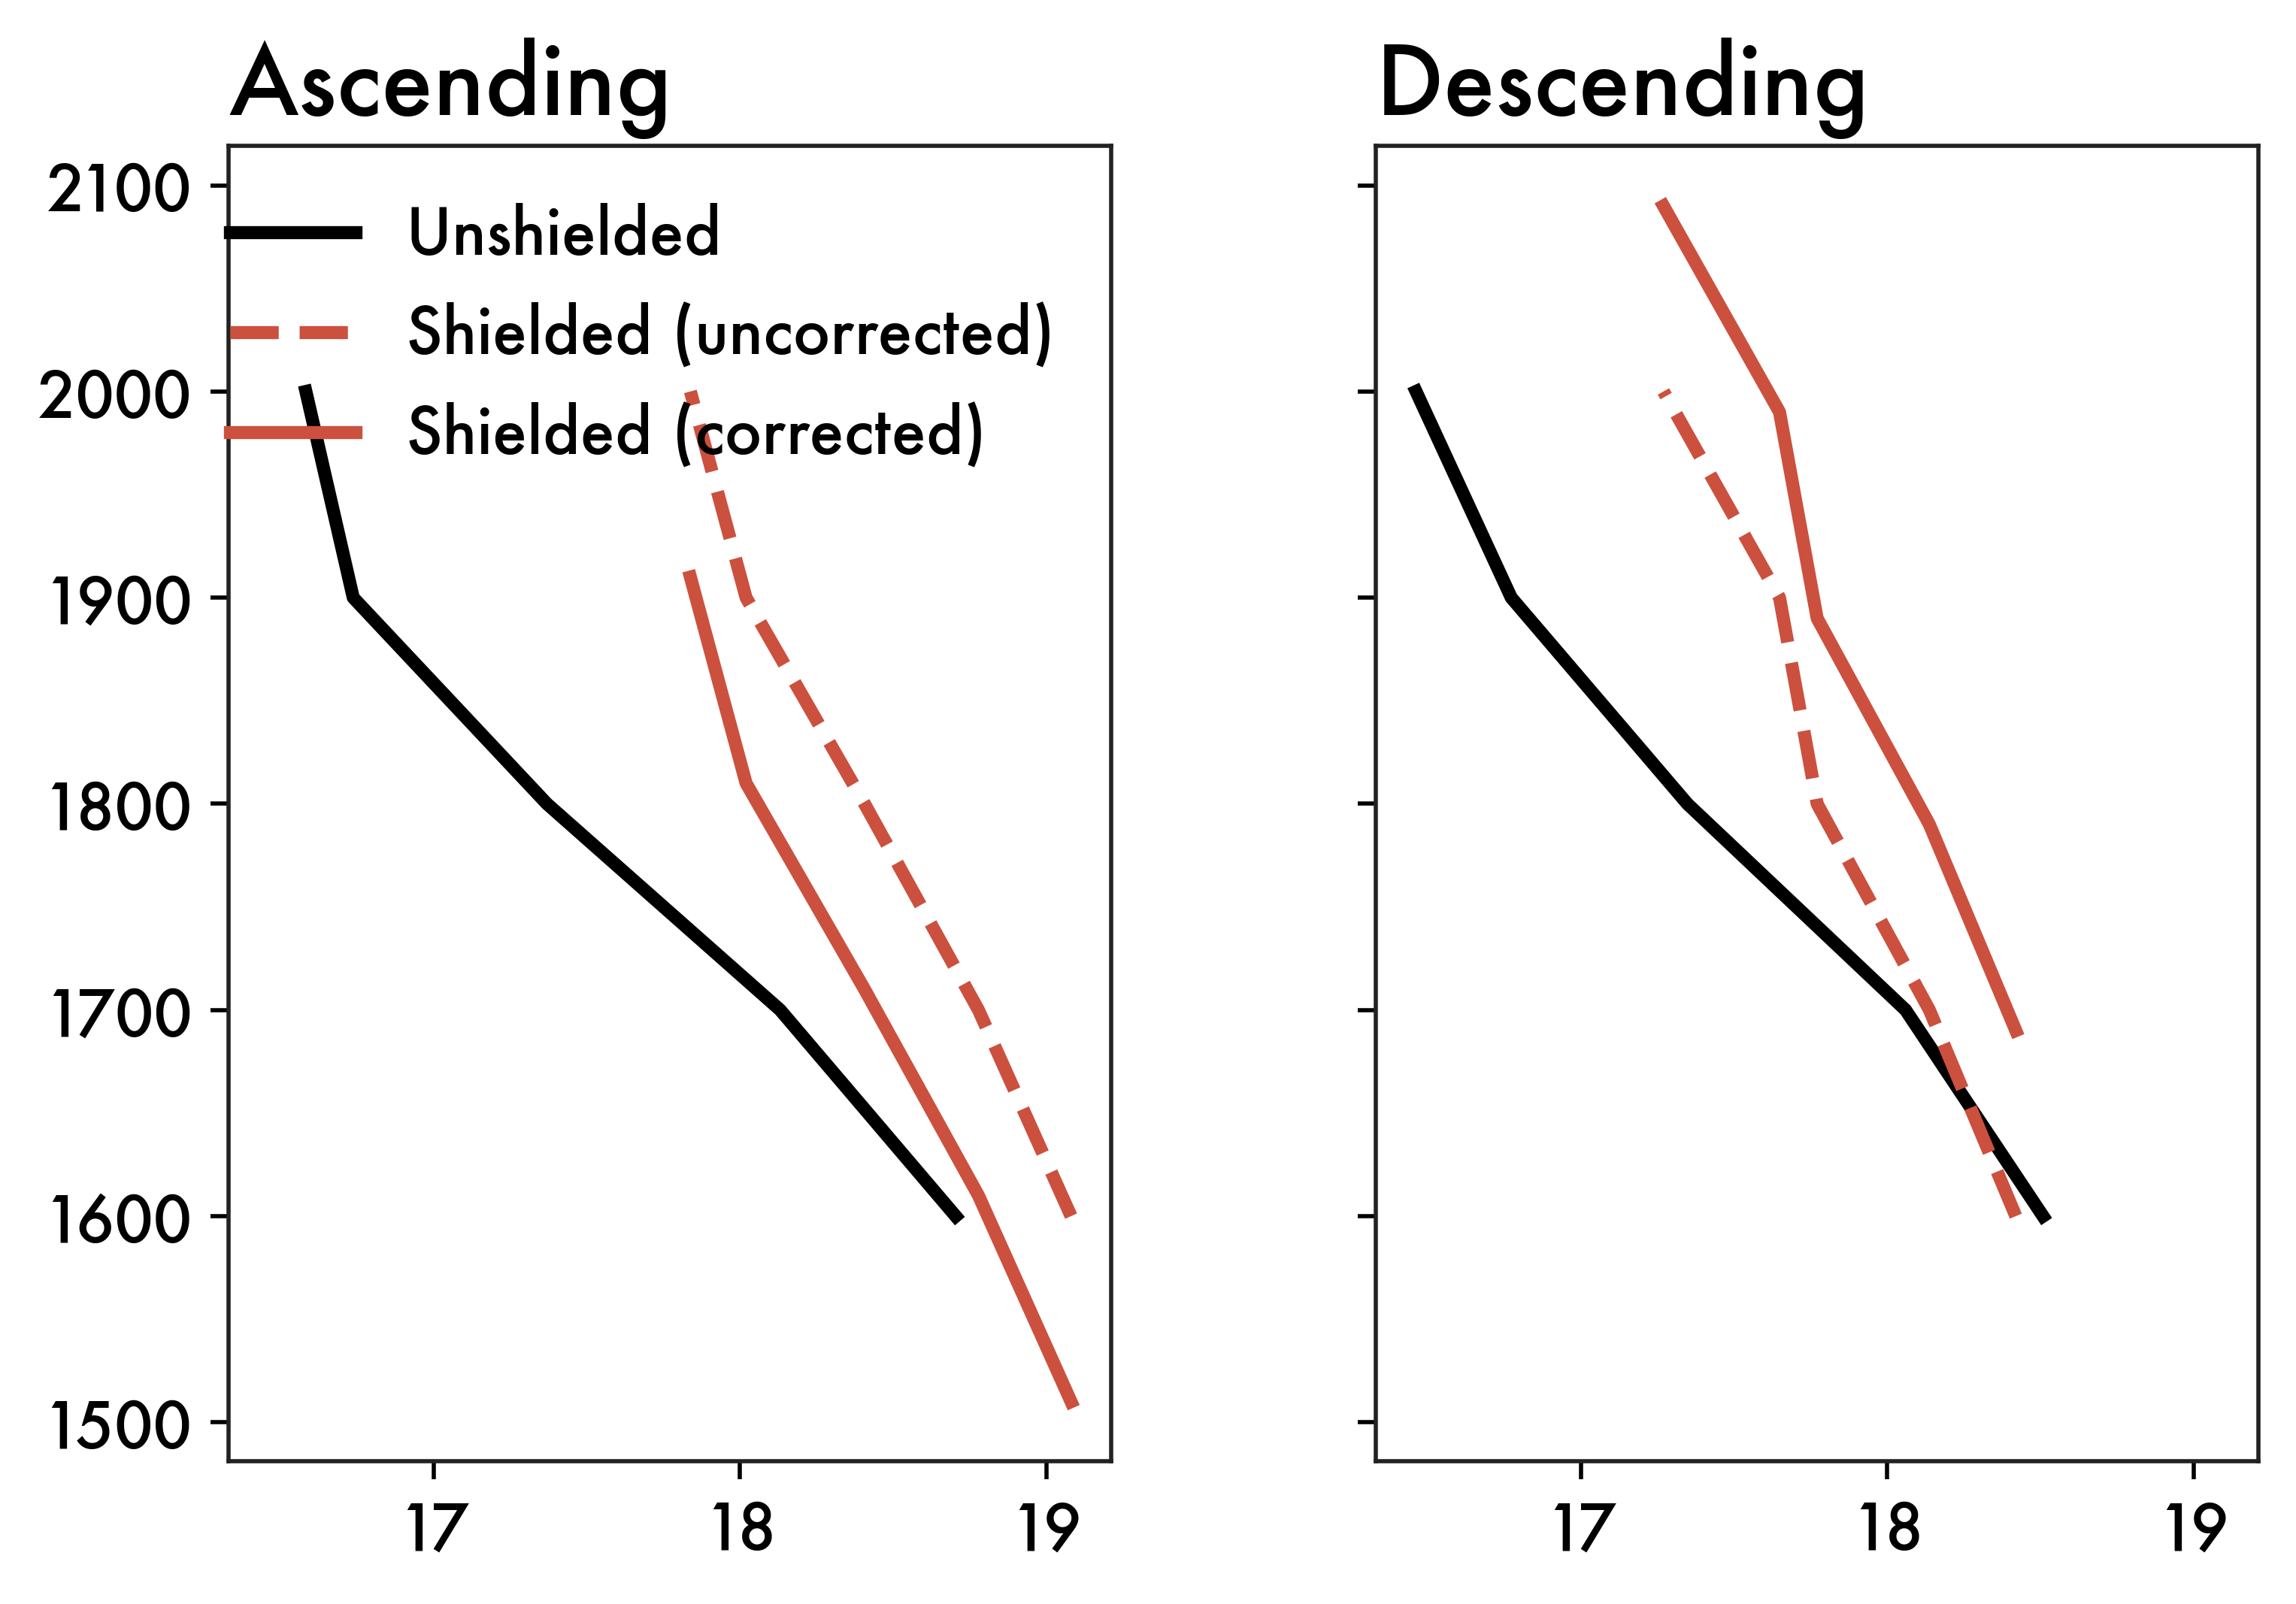

In [77]:
altbin = 5

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)

for ax, ver, df in zip(axes, ["ascending", "descending"], [a, d]):
    df["Alt_un"] = altbin * (df.Alt_un // altbin)
    df = df.groupby("Alt_un")

    ax.plot(
        df.Temp_un.mean(), df.mean().index, color="black", label="Unshielded"
    )
    ax.plot(
        df.Temp_asp.mean(),
        df.mean().index,
        color=red,
        ls="--",
        label="Shielded (uncorrected)",
    )

    if ver == "ascending":
        ax.plot(
            df.Temp_asp.mean(),
            df.mean().index - 90,
            color=red,
            label="Shielded (corrected)",
        )
    else:
        ax.plot(
            df.Temp_asp.mean(),
            df.mean().index + 90,
            color=red,
            label="Shielded (shifted 30s)",
        )

axes[0].legend()
axes[0].set_title("Ascending")
axes[1].set_title("Descending")

# Correct for lag

In [29]:
import scipy.stats as stats


def take_corr(x, y):
    df = pd.merge(
        x.dropna(), y.dropna(), left_index=True, right_index=True
    ).dropna()
    df.columns = ["x", "y"]

    x = df["x"]
    y = df["y"]

    x = (x - x.mean()) / x.std()
    y = (y - y.mean()) / y.std()
    (
        m,
        b,
        r,
        p,
        se,
    ) = stats.linregress(x, y)

    return (m, b, r)

In [30]:
print(prof[(prof.Type == "descending") * (prof.IOP == 17)])

    Unnamed: 0  index       Date  IOP        Type  Flight  profid  \
4            4      1 2023-05-27   17  descending       1     1.0   
5            5      2 2023-05-27   17  descending       1     2.0   
6            6      3 2023-05-27   17  descending       1     3.0   
7            7      4 2023-05-27   17  descending       1     4.0   
12          12      0 2023-05-27   17  descending       2     0.0   
13          13      1 2023-05-27   17  descending       2     1.0   
14          14      2 2023-05-27   17  descending       2     2.0   
15          15      3 2023-05-27   17  descending       2     3.0   

              starttime              endtime Aspirated Unaspirated  count  
4   2023-05-27 18:33:00  2023-05-27 18:34:31       X02         X06   92.0  
5   2023-05-27 18:36:54  2023-05-27 18:38:24       X02         X06   91.0  
6   2023-05-27 18:40:49  2023-05-27 18:42:18       X02         X06   91.0  
7   2023-05-27 18:44:43  2023-05-27 18:46:13       X02         X06   91.0 

In [31]:
profs = prof[(prof.IOP == 17)]  # & (prof.Type == "descending")]

In [32]:
print(prof.columns)

Index(['Unnamed: 0', 'index', 'Date', 'IOP', 'Type', 'Flight', 'profid',
       'starttime', 'endtime', 'Aspirated', 'Unaspirated', 'count'],
      dtype='object')


In [33]:
flts = prof.groupby(["IOP", "Flight"]).first()

flts["starttime"] = prof.groupby(["IOP", "Flight"])["starttime"].first()

flts["endtime"] = prof.groupby(["IOP", "Flight"])["endtime"].last()
flts = flts.reset_index()
print(flts)

    IOP  Flight  Unnamed: 0  index       Date       Type  profid  \
0    17       1           0      0 2023-05-27  ascending     0.0   
1    17       2           8      0 2023-05-27  ascending     0.0   
2    18       1          16      0 2023-05-30  ascending     0.0   
3    18       2          22      0 2023-05-30  ascending     0.0   
4    18       3          31      0 2023-05-30  ascending     0.0   
5    19       1          41      0 2023-06-01  ascending     0.0   
6    19       2          47      0 2023-06-01  ascending     0.0   
7    19       3          55      0 2023-06-01  ascending     0.0   
8    19       4          63      0 2023-06-01  ascending     0.0   
9    19       5          71      0 2023-06-01  ascending     0.0   
10   20       1          81      0 2023-06-02  ascending     0.0   
11   20       2          89      0 2023-06-02  ascending     0.0   
12   20       3          98      0 2023-06-02  ascending     0.0   
13   20       4         107      0 2023-06-02  a

In [83]:
all = []

for i in prof[(prof.IOP == 26)].index:
    flt = prof.loc[i]

    out = []
    for ver in ["Aspirated", "Unaspirated"]:
        path = f"{dataPath}/imet/{flt[ver]}-{flt.Date.strftime('%Y%m%d')}.csv"

        df = clean_imet_data(path)

        df = df[(df.Datetime >= flt.starttime) & (df.Datetime <= flt.endtime)]

        df = df.set_index("Datetime")

        out.append(df)

    if (len(out[0]) > 0) & (len(out[1]) > 0):
        out = pd.merge(
            out[0],
            out[1],
            how="outer",
            on="Datetime",
            suffixes=["_asp", "_un"],
        ).dropna()

    all.append(out)

print(all)

[                      P_asp  Temp_asp  RH_asp  Temp_RH_asp    Date_asp  \
Datetime                                                                 
2023-06-17 18:05:57  828.17     18.15    43.5        18.89  2023/06/17   
2023-06-17 18:05:58  827.86     18.06    43.3        18.85  2023/06/17   
2023-06-17 18:05:59  827.65     18.00    43.3        18.82  2023/06/17   
2023-06-17 18:06:00  827.32     18.01    43.3        18.79  2023/06/17   
2023-06-17 18:06:01  827.04     18.01    43.2        18.76  2023/06/17   
...                     ...       ...     ...          ...         ...   
2023-06-17 18:07:18  803.56     16.17    46.9        16.96  2023/06/17   
2023-06-17 18:07:19  803.18     16.18    47.0        16.96  2023/06/17   
2023-06-17 18:07:20  802.86     16.16    47.1        16.93  2023/06/17   
2023-06-17 18:07:21  802.54     16.21    47.2        16.92  2023/06/17   
2023-06-17 18:07:22  802.23     16.18    47.3        16.89  2023/06/17   

                     Time_asp     Lo

In [79]:
all = pd.concat(all).sort_index()

In [80]:
T_a = all.Temp_asp
T_u = all.Temp_un

-7 0.9641117075389448


Text(0, 0.5, 'Lag Correlation')

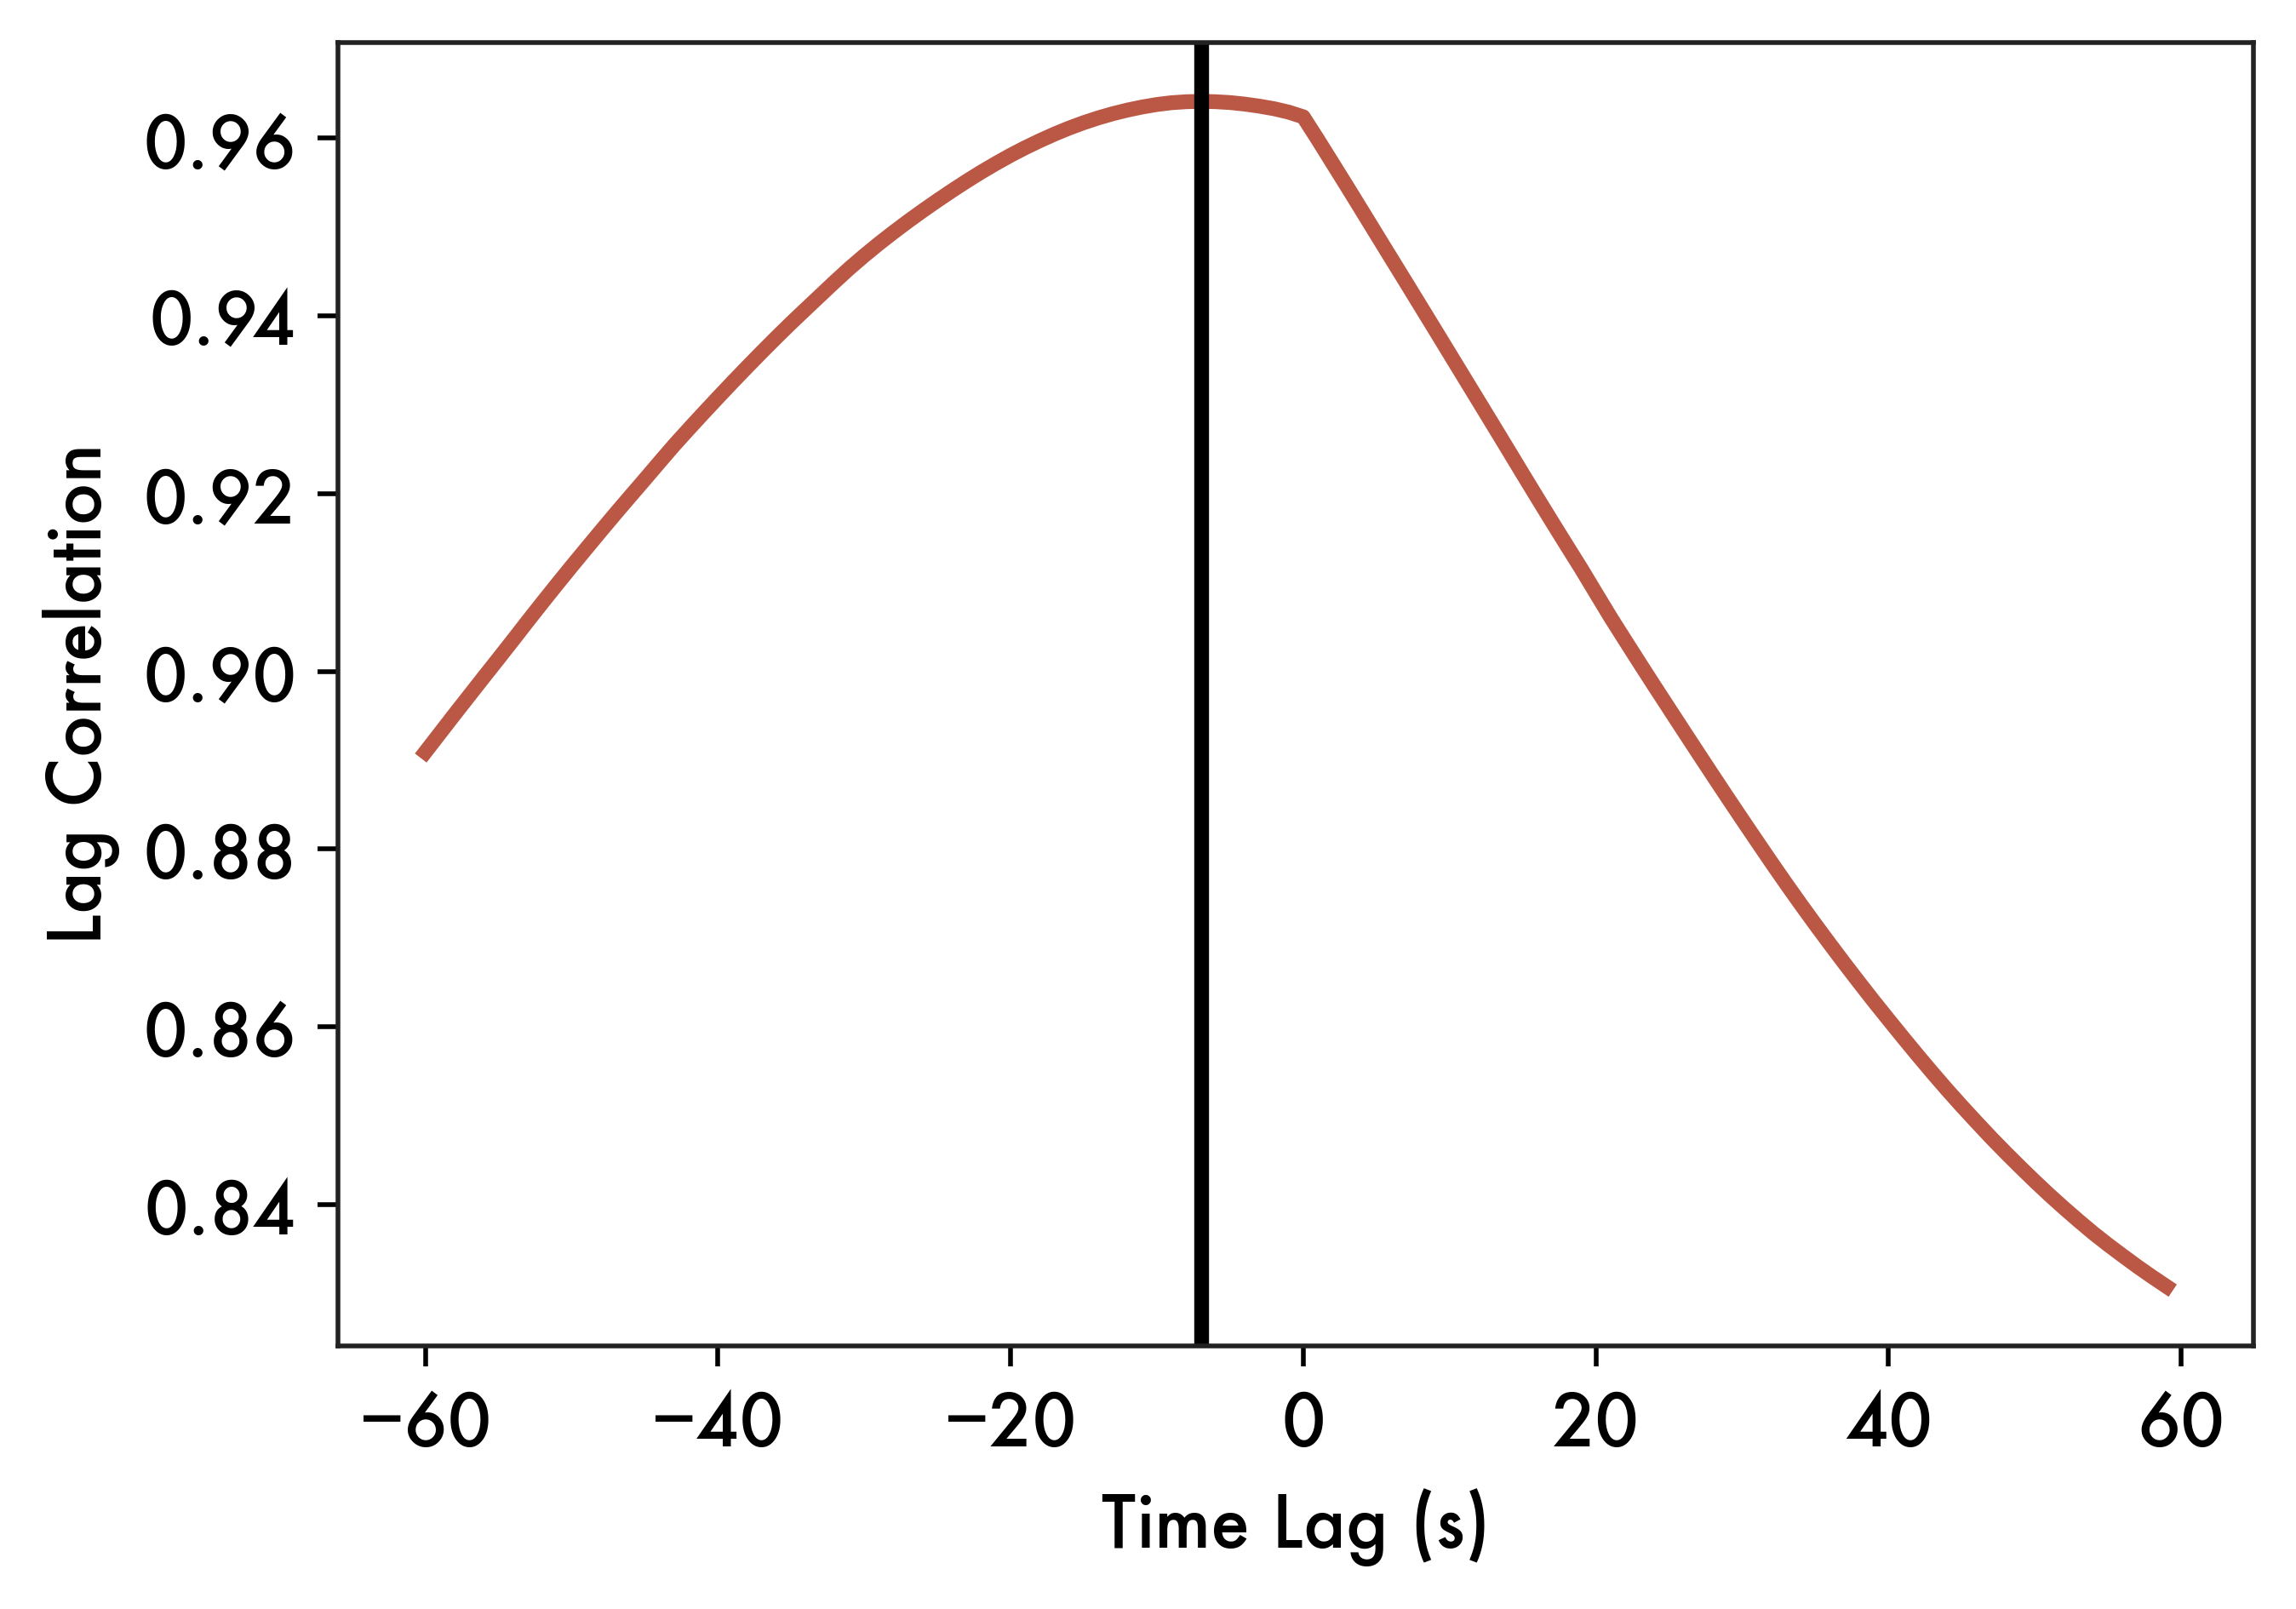

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
lags = np.arange(-60, 60)
out = []

for l in lags:
    out.append(take_corr(T_u, T_a.shift(l))[2])

plt.plot(lags, out)
print(lags[np.argmax(out)], np.max(out))
plt.axvline(lags[np.argmax(out)])
plt.xlabel("Time Lag (s)")
plt.ylabel("Lag Correlation")

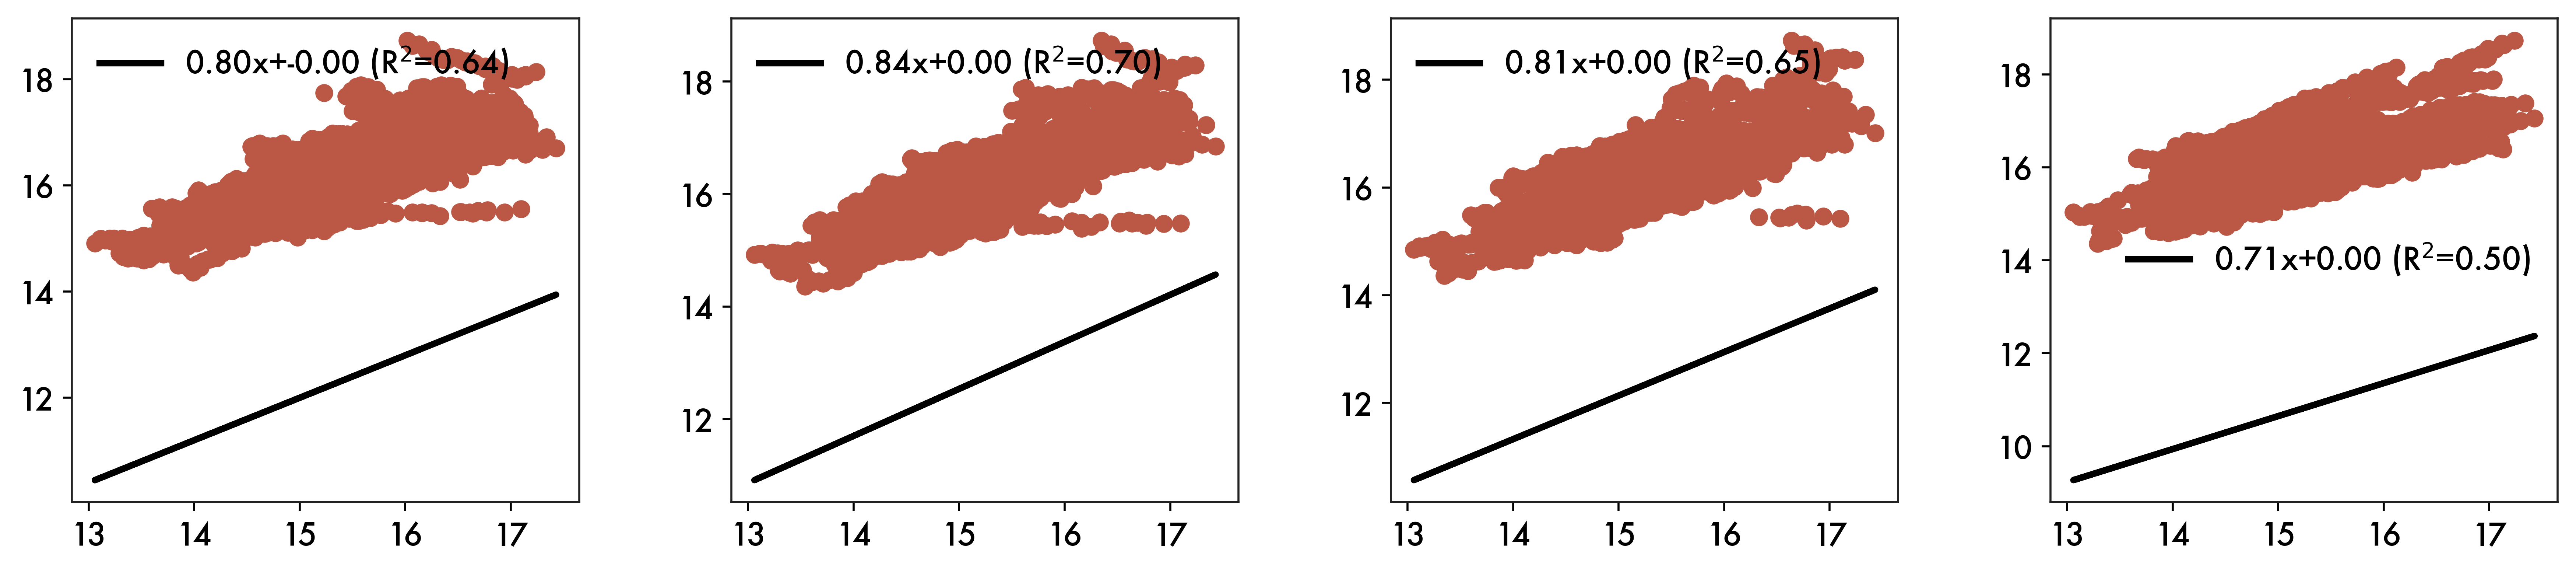

In [60]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

for ax, l in zip(axes, [-30, -20, -10, 0]):
    m, b, r = take_corr(T_u, T_a.shift(l))

    ax.scatter(T_u, T_a.shift(l))
    ax.plot(
        T_u,
        (m * T_u) + b,
        color="black",
        zorder=1,
        label=f"{m:.2f}x+{b:.2f} (R$^2$={r**2:.2f})",
    )

    ax.legend()